In [69]:
import sys, platform, os

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

from math import sqrt
import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.impute import KNNImputer
from datetime import date, datetime
import src.filler as fl
from src.filler import Debbuger
from src.dataframe import read_data_from_csv, show_error_metrics, split_data, windowing_nparray, windowing
from src.scaler import Scaler
from src.model import load_from_cache, save_trained_model

In [70]:
def linear_interpolate(df):
    data = df.copy()
    for column in df.columns:
        data[column] = df[column]\
            .interpolate(method='linear')\
            .interpolate(method='linear', limit_direction='backward')
        print(f'{column} - {data[column].isna().sum()}')
    return data

def random_forest(df):
    data = df.copy()
    for column in df.columns:
        print(f'{column} - {data[column].isna().sum()}')
        filler_model = fl.RandomForestFillerWithOneModel(
            n_estimators=1500, 
            n_in=3, 
            n_out=1, is_debug=False)
        data[column] = filler_model.filler(data[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def random_forest_hourly(df):
    data = df.copy()
    for column in df.columns:
        print(f'{column} - {data[column].isna().sum()}')
        filler_model = fl.RandomForestFillerWithOneModel(
            n_estimators=1500, 
            n_in=10, 
            n_out=1, is_debug=False)
        data[column] = filler_model.filler(data[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def dmd(df):
    data = df.copy()
    for column in df.columns:
        filler_model = fl.HodmdFiller(d_factor=0.99)
        data[column] = filler_model.dmd_filler(df[column])
        print(f'{column} - {data[column].isna().sum()}')
    return data

def fillzero(df):
    data = df.copy()
    for column in df.columns:
        data[column] = df[column].fillna(0)
        print(f'{column} - {data[column].isna().sum()}')
    return data



In [71]:
def agg_fill(df, filler_method):
    dict_index = {}
    df_temp = df.copy().resample('D').mean()
    for c in df_temp:
        dict_index[c] = df_temp[c].loc[np.isnan(df_temp[c].values)].index
    
    df = filler_method(df)

    df = agg(df)

    for c in df:
        df[c].loc[dict_index[c]] = pd.NA

    return df.loc[df.index >= df[~df.RADIATION.isna()].index[0]]

def agg(df):
    return df[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
        .resample('D') \
        .agg({'RADIATION': 'sum', 'TEMP': 'mean', 'HUMIDITY_h': 'mean'})\
        .replace(0, np.nan)


def get_dataframe(key, filename, filler_method, filler_before_agg=False, base_path='./cache'):
    file_cached = f'{base_path}/data/{key}.csv'
    
    if os.path.isfile(file_cached):
        return pd.read_csv(
            file_cached,
            sep=',',
            parse_dates=['Timestamp'],
            index_col=['Timestamp'])
    
    df = pd.read_csv(
        filename,
        sep=',',
        parse_dates=['Timestamp'],
        index_col=['Timestamp']).replace(0, np.nan)

    df = df[['RADIATION', 'TEMP', 'HUMIDITY_h']]
    df = df.loc[df.index >= df[~df.RADIATION.isna()].index[0]]

    if filler_before_agg:
        df = agg_fill(df, linear_interpolate)
        df = filler_method(df)
    else:
        df = agg(df)
        df = filler_method(df)

    print(df.isna().sum())
    df.to_csv(file_cached)
    return df


def train_model(key,
                model, 
                train_x, 
                train_y, 
                cache_path,
                is_debug=False,
                batch_size=16,
                validation_split=0.2,
                use_cache=False):
    
    from_cache = use_cache
    cache_path = f'{cache_path}/models'

    if from_cache:
        exist_cache, loaded_model = load_from_cache(key, cache_path)
        from_cache = exist_cache

    if from_cache and loaded_model is not None:
        loaded_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())
        return loaded_model


    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

    Debbuger.log(is_debug, train_x.shape, train_y.shape)
    Debbuger.log(is_debug, 'Model Summary', model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

    history = model.fit(train_x,
                        train_y,
                        epochs=5000,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[es],
                        workers=4,
                        use_multiprocessing=True)

    # plot history
    if is_debug:
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    if use_cache:
        save_trained_model(key, model, cache_path)

    return model


def create_folder_cache(base_path):
    if not os.path.exists(f'{base_path}/data'):
        os.makedirs(f'{base_path}/data')
    if not os.path.exists(f'{base_path}/models'):
        os.makedirs(f'{base_path}/models')




In [72]:
def forecast(key, 
             filename, 
             filler_method, 
             model_config, 
             train_ratio=0.9,
             step_back=5,
             filler_before_agg=False, 
             use_cache=False,
             is_debug=False,
             base_path='./cache'):
    base_path = base_path + f'/{key}'
    create_folder_cache(base_path)

    df = get_dataframe(key, filename, filler_method, filler_before_agg, base_path)

    scaler = Scaler(df, (0,1))
    df_scaled = scaler.get_dataframe_scaled()
    X, Y = windowing(df_scaled, predict_column='RADIATION', step_back=step_back, step_front=1)
    train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=train_ratio)

    model = train_model(key, 
                        model_config, 
                        train_x, 
                        train_y,        
                        base_path, 
                        use_cache=use_cache, 
                        is_debug=True)

    predict = model.predict(test_x)
    real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
    predict = scaler.scales['RADIATION'].inverse_transform(predict)

    # Avaliando previsão
    range_plot = 150
    print('Forecasting')
    show_error_metrics(real, predict)
    indice = df.index[-len(real):]
    pyplot.plot(indice[:range_plot], real.reshape(-1,1)[:range_plot], color='blue', label='Real')
    pyplot.plot(indice[:range_plot], predict.reshape(-1,1)[:range_plot], color='red', label='Previsão')
    pyplot.legend()
    pyplot.savefig(f'./img/{key}.svg')
    pyplot.savefig(f'./img/{key}.png')
    pyplot.show()

    # pyplot.plot(indice, real.reshape(-1,1), color='blue', label='Real')
    # pyplot.plot(indice, predict.reshape(-1,1), color='red', label='Previsão')
    # pyplot.legend()
    # pyplot.savefig(f'./img/{key}_extend.svg')
    # pyplot.savefig(f'./img/{key}.png')



In [73]:
city = 'vicosa'
filename = f'{base_path}/data/daily_{city}.csv'

step_back = 5
model = keras.Sequential()
model.add(LSTM(
    units=128,
    return_sequences = True,
    input_shape=(5, 3)
))
model.add(LSTM(
    units=64,
    return_sequences = True,
    dropout=0.25
))
model.add(LSTM(
    units=128,
    return_sequences = False,
    dropout=0.1
))
model.add(layers.Dense(1, 
    activation='relu'
))

20/20 [==============================] - 3s 12ms/step
Forecasting
Test R2: 0.531
Test MSE: 19501518.832
Test RMSE: 4416.052
Test MAE: 3422.126
Test MAPE: 0.259


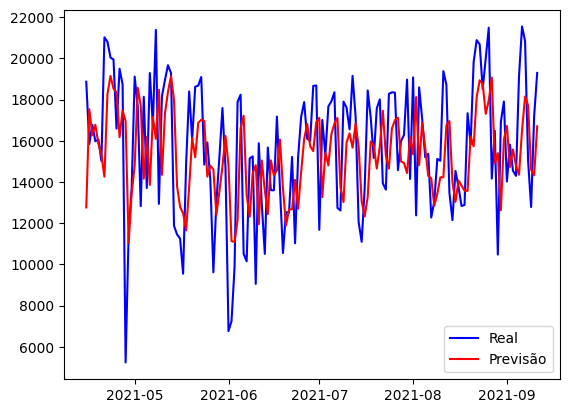

In [74]:
forecast(key=f'{city}_lstm_5_1_with_linear_interpolation_fill_before_agg', 
         filename=filename, 
         model_config=model,
         filler_method=linear_interpolate, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=True)

20/20 [==============================] - 1s 10ms/step
Forecasting
Test R2: 0.315
Test MSE: 17557809.977
Test RMSE: 4190.204
Test MAE: 3288.639
Test MAPE: 0.282


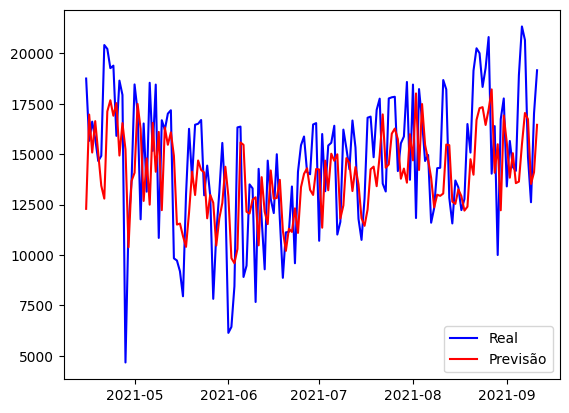

In [75]:
forecast(key=f'{city}_lstm_5_1_with_linear_interpolation', 
         filename=filename, 
         model_config=model,
         filler_method=linear_interpolate, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

20/20 [==============================] - 2s 15ms/step
Forecasting
Test R2: 0.281
Test MSE: 24560965.427
Test RMSE: 4955.902
Test MAE: 3614.790
Test MAPE: 0.263


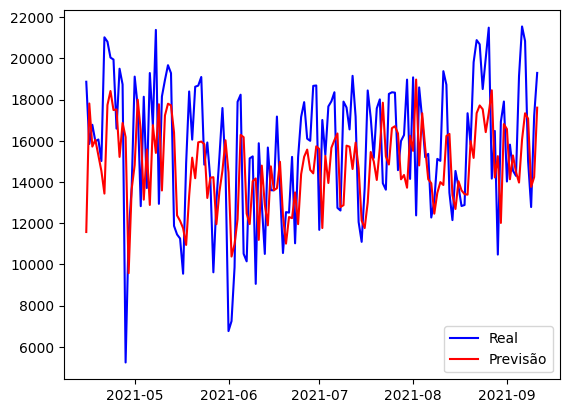

In [76]:
forecast(key=f'{city}_lstm_5_1_with_rf_fill_before_agg', 
         filename=filename, 
         model_config=model,
         filler_method=random_forest_hourly, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=True)

20/20 [==============================] - 2s 9ms/step
Forecasting
Test R2: 0.299
Test MSE: 17711840.458
Test RMSE: 4208.544
Test MAE: 3295.515
Test MAPE: 0.286


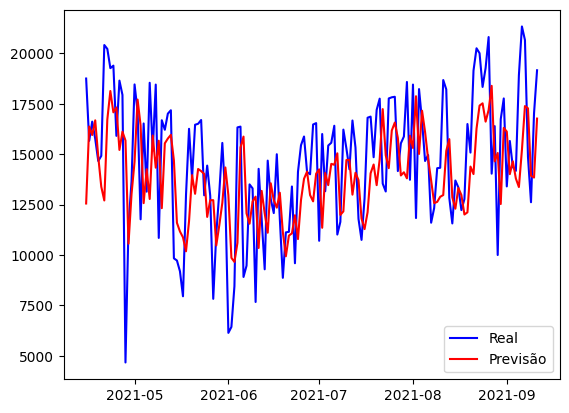

In [77]:
forecast(key=f'{city}_lstm_5_1_with_rf', 
         filename=filename, 
         model_config=model,
         filler_method=random_forest, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

20/20 [==============================] - 1s 12ms/step
Forecasting
Test R2: 0.431
Test MSE: 20774131.362
Test RMSE: 4557.865
Test MAE: 3485.399
Test MAPE: 0.262


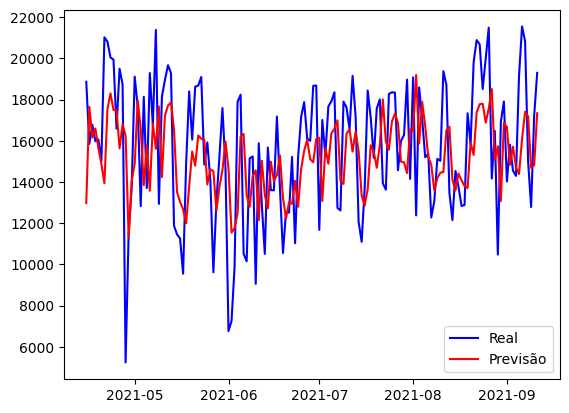

In [78]:
forecast(key=f'{city}_lstm_5_1_with_dmd_fill_before_agg', 
         filename=filename, 
         model_config=model,
         filler_method=dmd, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=True)

20/20 [==============================] - 1s 7ms/step
Forecasting
Test R2: 0.288
Test MSE: 17873735.141
Test RMSE: 4227.734
Test MAE: 3317.123
Test MAPE: 0.290


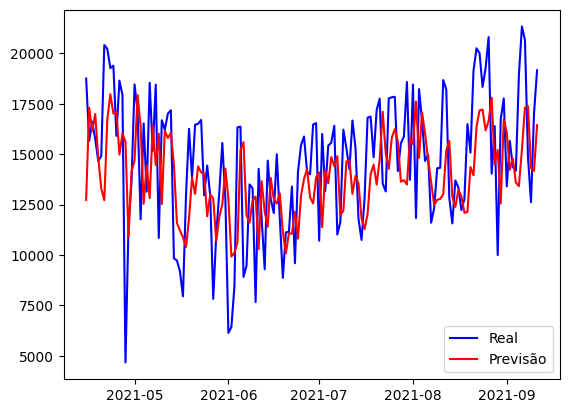

In [79]:
forecast(key=f'{city}_lstm_5_1_with_dmd', 
         filename=filename, 
         model_config=model,
         filler_method=dmd, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)

20/20 [==============================] - 1s 13ms/step
Forecasting
Test R2: 0.316
Test MSE: 18180434.716
Test RMSE: 4263.852
Test MAE: 3326.613
Test MAPE: 152826084754586400.000


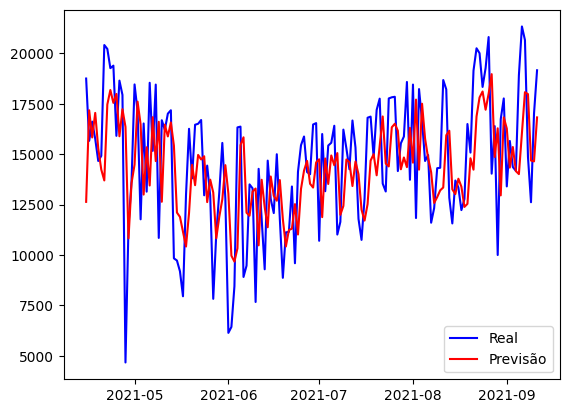

In [80]:
forecast(key=f'{city}_lstm_5_1_with_fillzero', 
         filename=filename, 
         model_config=model,
         filler_method=fillzero, 
         step_back=step_back, 
         use_cache=True, 
         filler_before_agg=False)